In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import numpy as np
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_log_error, r2_score, make_scorer
from sklearn.model_selection import learning_curve
from scipy.stats import norm
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

Importing plotly failed. Interactive plots will not work.


In [2]:
train = pd.read_csv('training.csv', parse_dates=['transaction_date'])
card_group = pd.read_csv('mcc_group_definition.csv')
transaction = pd.read_csv('transaction_types.csv')


In [3]:
train = train.drop(['dataset_transaction','dataset_user'], axis=1)
# merge data
train2 = train.merge(card_group, on='mcc_group', how='left').drop('mcc_group', axis=1)

train2 = (train2
          .merge(transaction, left_on='transaction_type', right_on='type', suffixes=('_card', '_transaction'))
          .drop(['type','transaction_type'], axis=1))


## The data of primary interest which is the amount_n26_currecy is clearly postively sckwed

In [4]:
# X = train2.values
# history = [X[i] for i in range(10)]
# yhat = np.mean([history[i] for i in range(10)])


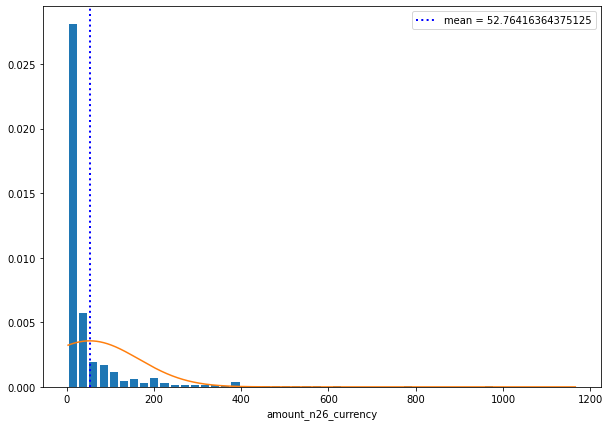

In [5]:
plt.figure(figsize=(10, 7))
plt.hist(train2.amount_n26_currency, bins=50,rwidth=0.8,density=True)
# plt.show()
rng = np.arange(train2.amount_n26_currency.min(), train2.amount_n26_currency.max(), 0.1)
plt.plot(rng,norm.pdf(rng,train2.amount_n26_currency.mean(),train2.amount_n26_currency.std()))
# plt.vlines(, 0, 0.05, color='crimson', ls=':',lw=2, label='mean')
plt.axvline(train2.amount_n26_currency.mean(),ls=':',lw=2, color='b', label= 'mean = '+str(train2.amount_n26_currency.mean()))
plt.xlabel('amount_n26_currency')
plt.ylabel('')
plt.legend()
plt.show()

In [6]:
train2['explanation_transaction'].unique()

array(['Debit Transfer', 'Credit Transfer', 'Debit Reversal',
       'MoneyBeam Transfer', 'Direct Debit', 'Presentment',
       'Cash26 deposit', 'Cash26 withdrawal', 'Transferwise Transaction'],
      dtype=object)

## we can deal with this by log transforming the series


In [7]:
# # log_amont = np.log(train2.amount_n26_currency)
# train2.amount_n26_currency = np.log(train2.amount_n26_currency)
# # test the skew
# # log_amont.skew() 
# plt.hist(train2.amount_n26_currency, bins=100,rwidth=0.8,density=True)
# # plt.show()
# rng = np.arange(train2.amount_n26_currency.min(), train2.amount_n26_currency.max(), 0.1)
# plt.plot(rng,norm.pdf(rng,train2.amount_n26_currency.mean(),train2.amount_n26_currency.std()))
# plt.axvline(train2.amount_n26_currency.mean(),ls=':',lw=2, color='b', label= 'mean = '+str(train2.amount_n26_currency.mean()))
# plt.xlabel('amount_n26_currency')
# plt.ylabel('')
# plt.legend()
# plt.show()

## The log transformation has clearly showed some progress in terms of the data 

In [8]:
## add code for outlier detection

# observing weekly trends


In [9]:
# aggregate the last 2 functions

def plot_bar(feature,data):
    g = sns.catplot(x=feature, 
                    data=data,
                    order = data[feature].value_counts().index,
                    kind='count', 
                    height=7, 
                    aspect = 3, 
                    palette="Paired", 
                    edgecolor=".6")
    g.set_xticklabels(rotation=90)

def weekly_popularity_trend(feature):
    """
    Feature popularity on weekly basis
    """
    f = train2.groupby([feature, pd.Grouper(key='transaction_date',freq='W')]).size().reset_index()
    f['transaction_date'] = f['transaction_date'].dt.date
    f.columns = [feature,'transaction_date','count']
    sns.catplot(x="transaction_date", 
            y = 'count',
            hue = feature, 
            data=f, 
            kind='point', 
            height=7, 
            aspect= 1,
            palette='Paired')
    _ = plt.xticks(rotation=90)
    
    
def weekly_currency_trend(feature):
    """
    Mean transaction amount on a weekly basis for a given feature
    """
#    weekly spending trend to get an idea about 
    f = train2.groupby([*feature, pd.Grouper(key='transaction_date',freq='W')])['amount_n26_currency'].mean().reset_index()
    f_std = train2.groupby([*feature, pd.Grouper(key='transaction_date',freq='W')])['amount_n26_currency'].std().reset_index()
    f['transaction_date'] = f['transaction_date'].dt.date
    
    f_std['transaction_date'] = f_std['transaction_date'].dt.date
    f.columns = [*feature,'transaction_date','mean']
    f_std.columns = [*feature,'transaction_date','std']
    
    f_final = f.merge(f_std)
    hue = feature[0]
    
    # correlating features or maybe not! 
    if feature[1]:
        g = sns.catplot(x="transaction_date", 
                y = 'mean',
                hue = feature[0],
                col = feature[1],
                data=f, 
                kind='point', 
                height = 7,
                aspect = 1.5,
                palette=sns.color_palette("bright", 10)
                )
        g.set_xticklabels(rotation=90)
    else:
        g = sns.catplot(x="transaction_date", 
        y = 'mean',
        hue = feature[0],
        col = feature[1],
        data=f, 
        kind='point', 
        height = 7,
        aspect = 1.5,
        palette=sns.color_palette("bright", 10)
        )
        g.set_xticklabels(rotation=90)
        autocorrelation_plot(f['mean'])
#     x = np.arange(len(f['mean']))
#   plt.errorbar(x,f_final['mean'],yerr=f_final['std'])


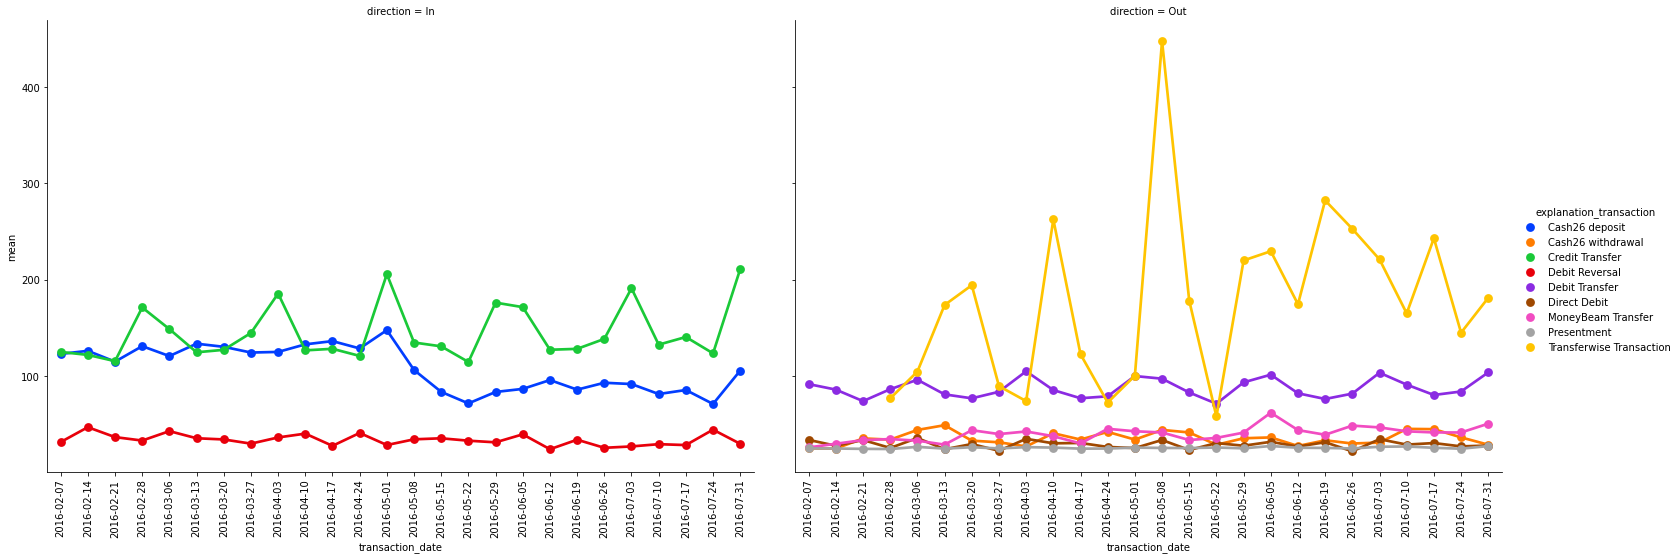

In [10]:
# does not make sense to make a error bar for the direction
weekly_currency_trend(feature = ['explanation_transaction','direction'])



# At the end of each month major income occures as should be

## Feature Engineering date

In [11]:
class feature_engineering_datetime(TransformerMixin, BaseEstimator):
    

    def fit(self, data, label=None):
        return self

    def transform(self, data, label = None):
        data[f"{'transaction'}_weekday"] = data['transaction_date'].dt.dayofweek
        data[f"{'transaction'}_week"] = data['transaction_date'].dt.isocalendar().week
        data[f"{'transaction'}_day_week"] = data['transaction_date'].dt.day
#         data[f"{'transaction'}_week_year"] = data['transaction_date'].dt.year
        self.names = data[[x for x in data.columns if 'prev_' in x]].columns.tolist()
       
        return data[(elem for elem in data.columns if '_week' in elem)].values
    def feature_names(self):
        return self.names

In [12]:
class feature_engineering(TransformerMixin, BaseEstimator):
    

    def fit(self, data, label=None):
        return self

    def transform(self, data, label = None):
        #lags= [1,5,7,14]
        lags = [7,14]
        for lag in lags:
            print('in timestamp of lags')
        # lag feature
        #A moving average is commonly used with time series data to smooth out short-term fluctuations and highlight longer-term trends or cycles.
            data[f'prev_amount_mean_{lag}'] = data.groupby(['user_id'])['amount_n26_currency'].shift(lag).fillna(0)
#             # rolling average
            # grouping by the user id and then calculating the mean. Makes sense
            data[f'prev_amount_rolling_mean_{lag}'] = data.groupby(['user_id'])['amount_n26_currency'].shift(lag).rolling(2).mean().fillna(0)
#             # cumulative average
            data[f'prev_amount_expand_mean_{lag}'] = data.groupby(['user_id'])['amount_n26_currency'].shift(lag).expanding().mean().fillna(0)
#             # exponential moving average
            data[f'prev_amount_ewm_mean_{lag}'] = data.groupby(['user_id'])['amount_n26_currency'].shift(lag).ewm(0.1).mean().fillna(0)
         
#             # rolling average
            # grouping by the user id and then calculating the mean. Makes sense
            data[f'prev_amount_rolling_std_{lag}'] = data.groupby(['user_id'])['amount_n26_currency'].shift(lag).rolling(2).std().fillna(0)
#             # cumulative average
            data[f'prev_amount_expand_std_{lag}'] = data.groupby(['user_id'])['amount_n26_currency'].shift(lag).expanding().std().fillna(0)
#             # exponential moving average
            data[f'prev_amount_ewm_std_{lag}'] = data.groupby(['user_id'])['amount_n26_currency'].shift(lag).ewm(0.1).std().fillna(0)
         
            ##
#             # rolling average
            # grouping by the user id and then calculating the mean. Makes sense
            data[f'prev_amount_rolling_min_{lag}'] = data.groupby(['user_id'])['amount_n26_currency'].shift(lag).rolling(2).min().fillna(0)
#             # cumulative average
            data[f'prev_amount_expand_min_{lag}'] = data.groupby(['user_id'])['amount_n26_currency'].shift(lag).expanding().min().fillna(0)
#             # exponential moving average
#             data[f'prev_amount_ewm_min_{lag}'] = data.groupby(['user_id'])['amount_n26_currency'].shift(lag).ewm(0.1).min().fillna(0)
         
        
        #             # rolling average
            # grouping by the user id and then calculating the mean. Makes sense
            data[f'prev_amount_rolling_max_{lag}'] = data.groupby(['user_id'])['amount_n26_currency'].shift(lag).rolling(2).max().fillna(0)
#             # cumulative average
            data[f'prev_amount_expand_max_{lag}'] = data.groupby(['user_id'])['amount_n26_currency'].shift(lag).expanding().max().fillna(0)
#             # exponential moving average
#             data[f'prev_amount_ewm_max_{lag}'] = data.groupby(['user_id'])['amount_n26_currency'].shift(lag).ewm(0.1).max().fillna(0)
         
        
        self.names = data[[x for x in data.columns if 'prev_' in x]].columns.tolist()
#         if label:
#             y = df[label]
#             return data[[x for x in data.columns if 'prev_' in x]].values, y.values
    
        return data[[x for x in data.columns if 'prev_' in x]].values
        

    def feature_names(self):
        return self.names
    

In [13]:
# def feature_engineering_arima(data):
#     np.log(data['am'])

## pipeline creation for the model


In [14]:
# Feature transformation pipeline
# It combines all sorts of features that are transformed and combine them
# to generate an output
def generate_pipeline(**kwargs):
    

    features = ColumnTransformer(
        [('date_time_features',feature_engineering_datetime(), ['transaction_date']),
         ('lag_features',feature_engineering(), ['user_id','amount_n26_currency'])
        ],  
        remainder='drop',
        sparse_threshold=0.3,
        n_jobs=None,
        transformer_weights=None
    )

    
#     # can use any sklearn estimator
#     clf = XGBRegressor(n_estimators=100, random_state=42, booster='gbtree')
        
  
    feature_transformer = Pipeline([
        ('features', features),
        # ('clf', clf)
    ]) 
    return feature_transformer

In [15]:
in_data, out_data= train2[(mask:=train2['direction'] == "In")], train2[~mask]
out_data = out_data.drop(['direction','explanation_card','explanation_transaction','agent'], axis=1)

## Segregatting in data for income prediction

In [52]:
out_data = out_data.sort_values(['user_id','transaction_date']).reset_index(drop=True)
# split data set 
train = out_data[out_data['transaction_date'].dt.month < 7].reset_index(drop=True) # from feb to june
test = out_data[out_data['transaction_date'].dt.month == 7].reset_index(drop=True) # test july
y_train = np.log1p(train['amount_n26_currency'])
y_test = np.log1p(test['amount_n26_currency'])

In [ ]:
type(y_train)

In [ ]:
# def autocorrelationplot()

In [ ]:
def transformed_features(train):
    features = generate_pipeline()# fit and transforming the data
    features.fit(train)
    transformed_data = features.transform(train)
    return transformed_data

In [ ]:
# # cut out autoarima and make arima.
# # Auto arima is screwed!
# def auto_arima_model(train,test):
#     stepwise_model = auto_arima(train['amount_n26_currency'], start_p=1, start_q=1,
#                                max_p=3, max_q=3, m=7,
#                                start_P=0, seasonal=False,
#                                d=1, D=1, trace=True,
#                                error_action='ignore',  
#                                suppress_warnings=True, 
#                                stepwise=True)
#     stepwise_model.aic()
#     stepwise_model.fit(train['amount_n26_currency'])
#     stepwise_model.predict()
#     future_forecast = stepwise_model.predict(n_periods=len(test))
#     future_forecast = pd.DataFrame(future_forecast,
#                                    index=test.index,
#                                    columns=['prediction'])
#     return future_forecast
# #     pd.concat([test, future_forecast], axis=1).iplot()


# let us test auto arima for tuning lags


In [ ]:
# train_arima = out_data[out_data['transaction_date'].dt.month <= 7].reset_index(drop=True) # from feb to july
# # test dataset does not change. It is same as test
# future_forecast = auto_arima_model(train_arima,test)

In [ ]:
# ## concatenate the future and train values from the date of the test series 
# x = np.arange(len(test))
# auto_arima_preds = pd.concat([test,future_forecast],axis=1)

In [ ]:
# train_with_july = out_data[out_data['transaction_date'].dt.month <= 7].reset_index(drop=True) # from feb to july


## prophet model



In [ ]:
def prophet_model(train):
    model = Prophet(interval_width=0.95)
    train_subdf = train[['transaction_date','amount_n26_currency']]
    train_subdf = train_subdf.rename(columns={'transaction_date':'ds', 'amount_n26_currency':'y'})
#     subdf['y'] = original_log_train_data
    model.fit(train_subdf)
    # period = 31 for 31 days in August. 
    future_dataframe = model.make_future_dataframe(periods=31,freq='D')
    future_forecast = model.predict(future_dataframe)

    return model, future_forecast

In [ ]:
def plot_prophet(model, future_forecast_prophet):
    plt.figure(figsize=(25,15))
    plot2 = model.plot_components(future_forecast_prophet)
    fig = model.plot(future_forecast_prophet)
    a = add_changepoints_to_plot(fig.gca(), model,future_forecast_prophet)
#     plt.bar(future_forecast_prophet['ds'],future_forecast_prophet['weekly'])

    

In [ ]:
model, future_forecast_prophet = prophet_model(train_with_july)
plot_prophet(model, future_forecast_prophet)

In [ ]:
future_forecast_prophet
# review trend
plt.plot(future_forecast_prophet['yhat'])

In [ ]:
# def arima_model(train,test):
#     history = [x for x in train['amount_n26_currency']]
#     predictions = list()
    
#     for t in range(len(test)):
#         model = sm.tsa.arima.ARIMA(history, order=(1,1,2))
#         model_fit = model.fit()
#         output = model_fit.forecast()
#         yhat = output[0]
#         predictions.append(yhat)
#         obs = test['amount_n26_currency'][t]
#         history.append(obs)
#         print('predicted=%f, expected=%f' % (yhat, obs))
        
#     rmse = np.sqrt(mean_squared_error(test, predictions))
#     print('Test RMSE: %.3f' % rmse)
#     # plot forecasts against actual outcomes
#     pyplot.plot(test)
#     pyplot.plot(predictions, color='red')
#     pyplot.show()
#     return predictions
# #     print(model_fit.summary())
# #     residuals = pd.DataFrame(model_fit.resid)
# #     plt.figure(figsize=(15,15))
# #     fig, ax = plt.subplots(1,2)
# #     residuals.plot(title="Residuals", ax=ax[0])
# #     residuals.plot(kind='kde', title='Density', ax=ax[1])
# #     forecast_arima = model_fit.forecast()
# #     plt.show()
# #     return forecast_arima



In [ ]:
arima_forecast = arima_model(train_with_july,test)

In [49]:
model = generate_pipeline()

xgb = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
# model.fit(model.transform(train),)

In [50]:
model.fit(train)

in timestamp of lags
in timestamp of lags


Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('date_time_features',
                                                  feature_engineering_datetime(),
                                                  ['transaction_date']),
                                                 ('lag_features',
                                                  feature_engineering(),
                                                  ['user_id',
                                                   'amount_n26_currency'])]))])

In [53]:
xgb.fit(model.transform(train), y_train)

in timestamp of lags
in timestamp of lags


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [55]:
y_test[0]

2.302585092994046

In [56]:
o = model.transform(test)

in timestamp of lags
in timestamp of lags


In [ ]:
np.shape(y_train)

In [60]:
np.shape(model.transform(train))

in timestamp of lags
in timestamp of lags


(277463, 25)

In [65]:
model.transform(test)

in timestamp of lags
in timestamp of lags


array([[2, 27, 6, ..., 0.0, 0.0, 0.0],
       [3, 27, 7, ..., 0.0, 0.0, 0.0],
       [2, 28, 13, ..., 0.0, 0.0, 0.0],
       ...,
       [3, 29, 21, ..., 3.0, 18.0, 1160.0],
       [6, 29, 24, ..., 3.0, 18.0, 1160.0],
       [1, 30, 26, ..., 3.0, 45.0, 1160.0]], dtype=object)

In [63]:
np.shape(model.transform(test))

in timestamp of lags
in timestamp of lags


(58958, 25)

In [70]:
say = o[0]

In [72]:
say = say.reshape(1,25)

In [74]:
np.shape(say)

(1, 25)

In [75]:
xgb.predict(say)

array([4.93904], dtype=float32)

In [77]:
y_test[0]

2.302585092994046

In [ ]:
t

In [68]:
np.shape(o[0])

(25,)

In [59]:
xgb.predict(o[0])

XGBoostError: [02:17:34] ../src/predictor/cpu_predictor.cc:341: Check failed: m->NumColumns() == model.learner_model_param->num_feature (1 vs. 25) : Number of columns in data must equal to trained model.
Stack trace:
  [bt] (0) /home/gebruiker/.local/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x21eca9) [0x7f077b837ca9]
  [bt] (1) /home/gebruiker/.local/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x23676a) [0x7f077b84f76a]
  [bt] (2) /home/gebruiker/.local/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x237b79) [0x7f077b850b79]
  [bt] (3) /home/gebruiker/.local/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x189a5d) [0x7f077b7a2a5d]
  [bt] (4) /home/gebruiker/.local/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x1bf530) [0x7f077b7d8530]
  [bt] (5) /home/gebruiker/.local/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0xb5749) [0x7f077b6ce749]
  [bt] (6) /home/gebruiker/.local/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(XGBoosterPredictFromDense+0x28d) [0x7f077b6b452d]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.7(+0x6ff5) [0x7f080ec87ff5]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.7(+0x640a) [0x7f080ec8740a]



In [ ]:
a = model.transform(test)

In [ ]:
xgb.predict(model.transform(test))

## XGboost

In [25]:
train = out_data[out_data['transaction_date'].dt.month < 7].reset_index(drop=True) # from feb to june
test = out_data[out_data['transaction_date'].dt.month == 7].reset_index(drop=True) # test july
model = generate_pipeline()
model.fit(train)
transformed_train = model.transform(train)
transformed_test = model.transform(test)
# should the data be transformed after each loop?

# history = [x for x in transformed_train]
# trainY = train['amount_n26_currency']
# testY = test['amount_n26_currency']
    

in timestamp of lags
in timestamp of lags
in timestamp of lags
in timestamp of lags
in timestamp of lags
in timestamp of lags


In [36]:
history = [x for x in transformed_train]

In [38]:
# list of ararys

list

In [40]:
transformed_train[0] = transformed_test[0]

In [48]:
transformed_train

array([[4, 26, 1, ..., 0.0, 0.0, 0.0],
       [0, 5, 1, ..., 0.0, 0.0, 0.0],
       [0, 5, 1, ..., 0.0, 0.0, 0.0],
       ...,
       [1, 26, 28, ..., 3.0, 63.0, 1160.0],
       [1, 26, 28, ..., 3.0, 63.0, 1160.0],
       [3, 26, 30, ..., 3.0, 58.0, 1160.0]], dtype=object)

array([[4, 26, 1, ..., 0.0, 0.0, 0.0],
       [0, 5, 1, ..., 0.0, 0.0, 0.0],
       [0, 5, 1, ..., 0.0, 0.0, 0.0],
       ...,
       [1, 26, 28, ..., 3.0, 63.0, 1160.0],
       [3, 26, 30, ..., 3.0, 58.0, 1160.0],
       [4, 26, 1, ..., 0.0, 0.0, 0.0]], dtype=object)

In [46]:
a

<function ndarray.ravel>

In [ ]:
# the data pipeline needs to be created only once.

In [22]:
def xgb_forecast(transformed_train,trainy,transformed_test):
   

    # split data set 
#     train = out_data[out_data['transaction_date'].dt.month < 7].reset_index(drop=True) # from feb to june
#     test = out_data[out_data['transaction_date'].dt.month == 7].reset_index(drop=True) # test july
    

    
    
    
    # since the transformed train and test data is already
    # and array we do not have to convert that into an array

    xgb = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    xgb.fit(transformed_train,trainy)
    yhat = xgb.predict(transformed_test)

    return yhat

In [23]:
def walk_forward_validation(out_data):
    predictions = list()
    
    train = out_data[out_data['transaction_date'].dt.month < 7].reset_index(drop=True) # from feb to june
    test = out_data[out_data['transaction_date'].dt.month == 7].reset_index(drop=True) # test july
    model = generate_pipeline()
    model.fit(train)
    transformed_train = model.transform(train)
    transformed_test = model.transform(test)
    # should the data be transformed after each loop?
    
    history = [x for x in transformed_train]
    trainY = np.log1p(train['amount_n26_currency'])
    testY = np.log1p(test['amount_n26_currency'])
    history = transformed_train
    for i in range(len(transformed_test)):
        test, testy = transformed_test[i],testY[i]
        test = test.reshape(1,len(test))
        yhat = xgb_forecast(history ,trainY,test)
        predictions.append(yhat)
#         history.append(test)
        history = np.vstack( [ history , transformed_test[i]] )
        trainY.append(pd.Series(testY[i]),ignore_index= True)
        print(testy, yhat)
        
        
    

In [24]:
walk_forward_validation(out_data)



in timestamp of lags
in timestamp of lags
in timestamp of lags
in timestamp of lags
in timestamp of lags
in timestamp of lags


KeyboardInterrupt: 

In [ ]:
walk_forward_validation(transformed_train,y_train,transformed_test,y_test)

In [ ]:
len(train)